In [2]:
!pip3 install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMClassifier
import warnings

warnings.filterwarnings("ignore")

In [4]:
train = pd.read_csv("titanic/train.csv")
test = pd.read_csv("titanic/test.csv")

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_y = train[["Survived"]]

In [7]:
train["FamilySize"] = train["Parch"] + train["SibSp"] + 1
train["Alone"] = train["FamilySize"].map(lambda s: 1 if s == 1 else 0)
test["FamilySize"] = test["Parch"] + train["SibSp"] + 1
test["Alone"] = test["FamilySize"].map(lambda s: 1 if s == 1 else 0)

In [8]:
train["Sex"] = train["Sex"].map({"male": 1, "female": 0})
test["Sex"] = test["Sex"].map({"male": 1, "female": 0})

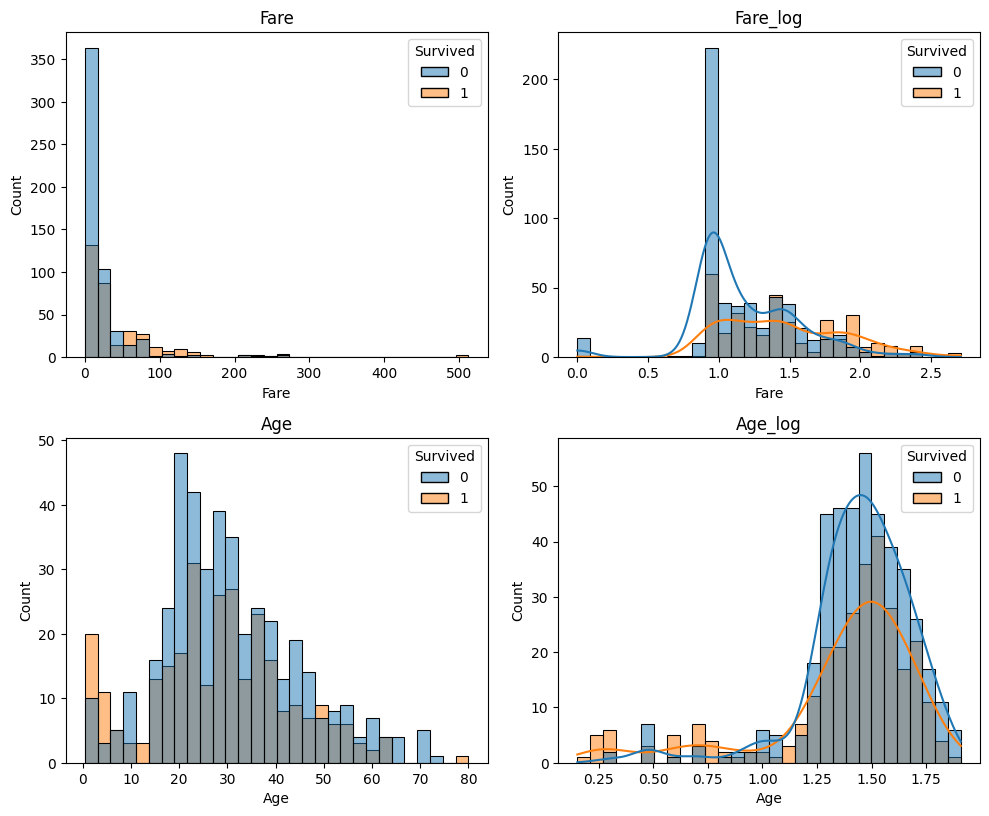

In [28]:
exp_feature = ["Fare", "Age"]
fig = plt.figure(figsize=(10, 20))
for i, var_name in enumerate(exp_feature):
    ax = fig.add_subplot(5, 2, 2 * i + 1)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=False, hue="Survived")
    ax.set_title(var_name)

    ax = fig.add_subplot(5, 2, 2 * i + 2)
    sns.histplot(
        data=np.log10(1 + train[[var_name]]).join(train[["Survived"]]),
        x=var_name,
        axes=ax,
        bins=30,
        kde=True,
        hue="Survived"
    )
    ax.set_title(var_name + "_log")
fig.tight_layout()
plt.show()

In [9]:
train[["Fare_log"]] = np.log10(1 + train[["Fare"]])
train = train.drop(columns=["Fare"])
test[["Fare_log"]] = np.log10(1 + test[["Fare"]])
test = test.drop(columns={"Fare"})

In [10]:
train = train.drop(columns=['Survived'])

In [11]:
spearman_corr_with_target = (
    train.corrwith(train_y["Survived"], method="spearman")
    .to_frame()
    .rename(columns={0: "corr"})
    .join(
        train.corrwith(train_y["Survived"], method="spearman")
        .to_frame()
        .abs()
        .rename(columns={0: "abs_corr"})
    )
).sort_values("abs_corr", ascending=False)
spearman_corr_with_target.head(10)

,corr,abs_corr
Sex,-0.543351,0.543351
Pclass,-0.339668,0.339668
Fare_log,0.323736,0.323736
Alone,-0.203367,0.203367
FamilySize,0.165463,0.165463
Parch,0.138266,0.138266
SibSp,0.088879,0.088879
Age,-0.052565,0.052565
PassengerId,-0.005007,0.005007


In [12]:
def plot_scores(scores, name):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title(name)

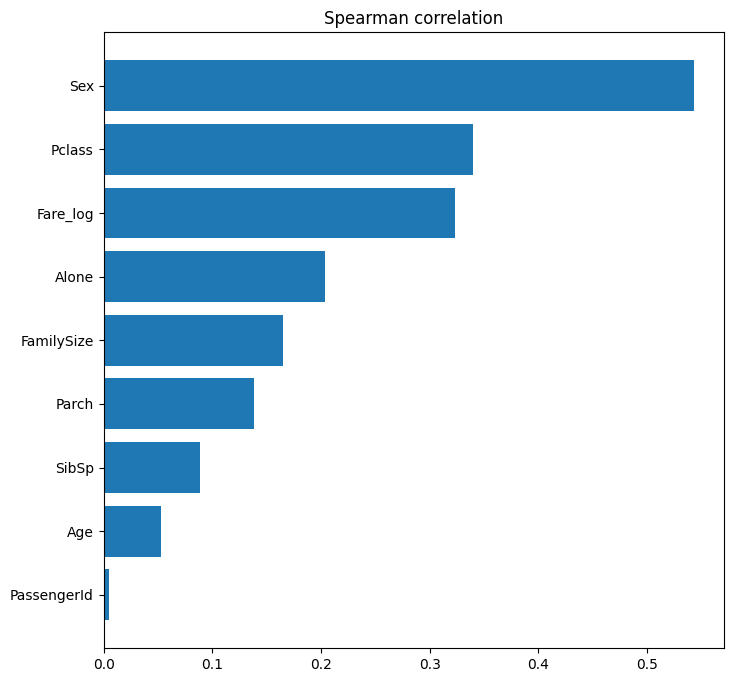

In [13]:
plt.figure(dpi=100, figsize=(8, 8))
plt.rcParams.update({"font.size":10})
plot_scores(spearman_corr_with_target.abs_corr, "Spearman correlation")

In [14]:
features = spearman_corr_with_target[
    spearman_corr_with_target.abs_corr > 0.03
].index.to_list()
features

['Sex', 'Pclass', 'Fare_log', 'Alone', 'FamilySize', 'Parch', 'SibSp', 'Age']

In [15]:
X = train[features]
X_test = test[features]

In [16]:
numerical_cols = [
    cname for cname in X.columns if X[cname].dtype in ["int64", "float64"]
]
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]


In [17]:
from sklearn.pipeline import Pipeline
numerical_transformer = Pipeline(steps=[("scaler", StandardScaler())])

categorical_transformer = Pipeline(
    steps=[
        (
            "onehot",
            OneHotEncoder(drop="if_binary", handle_unknown="ignore", sparse=False)
        )
    ]
)

In [18]:
ct = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ],
    remainder="passthrough"
)

In [19]:
X = ct.fit_transform(X)
X_test = ct.fit_transform(X_test)

In [20]:
print("Training set shape: ", X.shape)

Training set shape:  (891, 8)


In [21]:
classifiers = {
    "LGBM": LGBMClassifier(
        learning_rate=0.1, max_depth=2, n_estimators=50, random_state=0
    ),
}

In [22]:
FOLDS = 5
y = train_y.values

In [23]:
preds = np.zeros(len(X_test))
preds_train = np.zeros(len(X))

In [24]:
for key, classifier in classifiers.items():
    start = time.time()

    cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=0)

    score = 0
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train, X_valid = X[train_idx], X[val_idx]
        y_train, y_valid = y[train_idx], y[val_idx]

        clf= classifier
        clf.fit(X_train, y_train)

        preds += clf.predict_proba(X_test)[:, 1]
        preds_train += clf.predict_proba(X) [:, 1]
        score += clf.score(X_valid, y_valid)
        print(
            "Average infold validation accuracy: ",
            key,
            fold,
            np.round(100 * clf.score(X_valid, y_valid), 2),
        )
    score = score / FOLDS
    stop = time.time()
    print("Model: ", key)
    print("Average validation accuracy: ", np.round(100 * score, 2))
    print("Training time (mins): ", np.round((stop-start) / 60, 2))
    print("")

Average infold validation accuracy:  LGBM 0 85.47
Average infold validation accuracy:  LGBM 1 87.64
Average infold validation accuracy:  LGBM 2 85.96
Average infold validation accuracy:  LGBM 3 76.97
Average infold validation accuracy:  LGBM 4 79.78
Model:  LGBM
Average validation accuracy:  83.16
Training time (mins):  0.01



In [25]:
preds = preds / (FOLDS * len(classifiers))
preds_train = preds_train / (FOLDS * len(classifiers))

accuracy_score(y, preds_train > 0.5)

0.8383838383838383

In [ ]:
output = pd.DataFrame(
    {
        "PassengerId": test["PassengerId"], "Survived": (preds>0.5).astype(int)
    }
)
output.to_csv("submission.csv", index=False)